In [26]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
import base64
import pickle
from sympy import symbols, MatrixSymbol, lambdify, Matrix, pprint

from scipy.optimize import minimize
from matplotlib.ticker import FuncFormatter
from sympy import symbols, MatrixSymbol, lambdify
from matplotlib import cm
import random
import matplotlib.colors as mcolors
import scipy
import time
from pathlib import Path
import os
import ast
import pandas as pd
from pathlib import Path
from matplotlib.ticker import ScalarFormatter

from jax import jit, value_and_grad
import pennylane as qml
from functools import partial
from qiskit.circuit.library import *
from qiskit import *
from qiskit.quantum_info import *
import autograd
from pennylane.wires import Wires
import matplotlib.cm as cm
import base64
from qiskit import *
from qiskit.quantum_info import *
import os
import pickle
import re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

global_cache_data_digital = None
global_processed_files_digital = None

In [55]:
import pandas as pd
import numpy as np
import os
import pickle
from pathlib import Path
import re

# Debug function to log paths and data states
def debug_print(message, variable=None):
    if variable is not None:
        print(f"[DEBUG] {message}: {variable}")
    else:
        print(f"[DEBUG] {message}")

# Function to validate pickle files
def is_valid_pickle_file(file_path):
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                df = pickle.load(f)
            return True
        else:
            return False
    except EOFError:
        return False

# Extract last number from a string
def extract_last_number(text):
    numbers = re.findall(r'\d+', text)
    return int(numbers[-1]) if numbers else 0

# Read data from a pickle file
def read_jax_file(file_path, gate_name):
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
        costs = [float(i) for i in df['costs'][0]]
        infidelity = 1 - df['avg_infidelity'][0]
        num_params = 3 + int(df['controls'][0]) * int(df['reservoirs'][0]) * int(df['trotter_step'][0])
        test_results = [float(i) for i in df['test_results'][0]]
        return costs, infidelity, num_params, test_results

# Configuration
N_ctrl = 2
num_epochs = 1500
training_size = 20
factor = 0.1
trots = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
base_path = f'/Users/sophieblock/Downloads/debug/digital_results_trainable_global/trainsize_{training_size}_epoch{num_epochs}_bath_factor_{factor}/'

# Data structure to collect rows
rows = []

# Data extraction with baths included
for num_bath in range(3):  # Assuming baths are numbered as 0, 1, 2
    ctrl_path = os.path.join(base_path, f"{num_bath}_num_baths/")
    gate_prefixes = [f'U{N_ctrl}']

    debug_print("Control Path", ctrl_path)

    for gate_prefix in gate_prefixes:
        for folder_name in sorted(os.listdir(ctrl_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name
                gate_path = os.path.join(ctrl_path, gate)

                for subfolder in sorted(os.listdir(gate_path), key=extract_last_number):
                    if 'reservoirs_' in subfolder:
                        reservoir_count = extract_last_number(subfolder)
                        subfolder_path = os.path.join(gate_path, subfolder)

                        for trotter_folder in sorted(os.listdir(subfolder_path), key=extract_last_number):
                            if 'trotter_step_' in trotter_folder:
                                trotter_step = extract_last_number(trotter_folder)
                                trotter_path = os.path.join(subfolder_path, trotter_folder, 'bath_False')

                                if not os.path.exists(trotter_path):
                                    debug_print("Path does not exist", trotter_path)
                                    continue

                                files_in_folder = os.listdir(trotter_path)

                                for file in files_in_folder:
                                    if not file.startswith('.'):
                                        pickle_file = os.path.join(trotter_path, file)

                                        if is_valid_pickle_file(Path(pickle_file)):
                                            costs, infidelity, total_params, test_results = read_jax_file(pickle_file, gate)

                                            # Calculate fidelity and other metrics
                                            fidelities = [1.0 - max(0, min(1.0, inf)) for inf in test_results]
                                            avg_fidelity = np.mean(fidelities)
                                            avg_infidelity = 1 - avg_fidelity
                                            std_fidelity = np.std(fidelities)

                                            # Store row data
                                            rows.append({
                                                'N_C': N_ctrl,
                                                'Bath': num_bath,
                                                'Gate': gate,
                                                'Reservoir Count': reservoir_count,
                                                'Trotter_Step': trotter_step,
                                                'Avg_Fidelity': avg_fidelity,
                                                'Std_Fidelity': std_fidelity,
                                                'Avg_Infidelity': avg_infidelity,
                                                'Var_Infidelity': np.var(fidelities),
                                                'Costs': costs,
                                                'Param_Count': total_params,
                                                'Run': Path(pickle_file).stem,
                                                'Test_Results': test_results,
                                            })

# Create a DataFrame from rows
all_data_df = pd.DataFrame(rows)



[DEBUG] Control Path: /Users/sophieblock/Downloads/debug/digital_results_trainable_global/trainsize_20_epoch1500_bath_factor_0.1/0_num_baths/
[DEBUG] Control Path: /Users/sophieblock/Downloads/debug/digital_results_trainable_global/trainsize_20_epoch1500_bath_factor_0.1/1_num_baths/
[DEBUG] Control Path: /Users/sophieblock/Downloads/debug/digital_results_trainable_global/trainsize_20_epoch1500_bath_factor_0.1/2_num_baths/


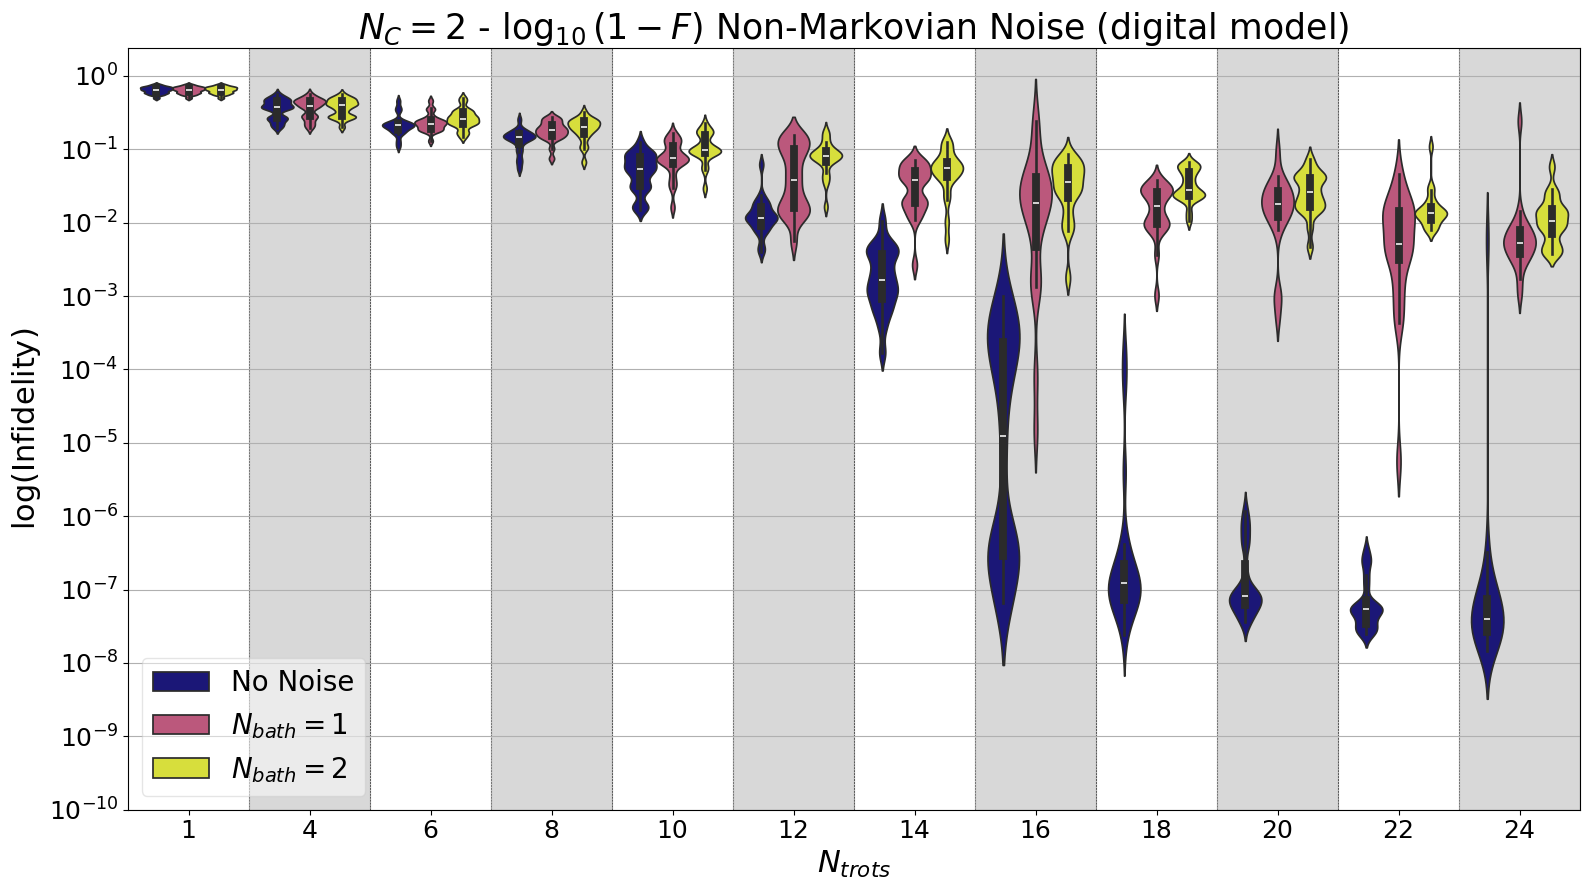

In [65]:
# Create a violin plot based on the new DataFrame
fig, ax = plt.subplots(figsize=(16, 9))

# Prepare data for plotting
all_data_df['Log(Infidelity)'] = np.log10(1 - all_data_df['Avg_Fidelity'].clip(lower=0, upper=1))
df_violin = all_data_df[['Trotter_Step', 'Bath', 'Log(Infidelity)']].rename(columns={'Bath': 'Num Bath'})

# Add vertical strips of color
unique_trotter_steps = sorted(df_violin['Trotter_Step'].unique())
positions = range(1, len(unique_trotter_steps) + 1)
for i, pos in enumerate(positions):
    ax.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4, zorder=0)
    if i % 2 == 0:  # Add strip for every other trotter step
        ax.axvspan(pos - 0.5, pos + 0.5, color='grey', alpha=0.3, zorder=0)

# Plot violin plot
sns.violinplot(
    x='Trotter_Step',
    y='Log(Infidelity)',
    hue='Num Bath',
    data=df_violin,
    ax=ax,
    bw_adjust=.5,
    density_norm='width',
    palette='plasma',
    inner="box",
    zorder=2
)

# Customize legend
handles, labels = ax.get_legend_handles_labels()
new_labels = ['No Noise' if int(label) == 0 else f'$N_{{bath}} = {label}$' for label in labels]
legend = ax.legend(handles, new_labels, title_fontsize=16, loc='lower left', fontsize=20, fancybox=True, framealpha=0.5)

# Customize grid and title
ax.yaxis.grid(True, zorder=1)
ax.xaxis.grid(False)

ax.set_title(f'$N_C = {N_ctrl}$ - $\log_{{10}}(1 - F)$ Non-Markovian Noise (digital model)', fontsize=25)
ax.set_xlabel('$N_{trots}$', fontsize=22)
ax.set_ylabel(r'$\log(\text{Infidelity})$', fontsize=22)

# Adjust Y-ticks for log scale
y_ticks = ax.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
min_tick = min(whole_y_ticks)
max_tick = max(whole_y_ticks)
whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
ax.set_yticks(whole_y_ticks)
ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Adjust tick sizes
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)

plt.tight_layout()
plt.show()

In [66]:
# Filter the DataFrame for the specified conditions
filtered_df = all_data_df[
    (all_data_df['Trotter_Step'] == 10) &
    (all_data_df['Bath'].isin([0, 1])) &
    (all_data_df['Avg_Fidelity'] < 0.8)
]

# Print the head of the filtered DataFrame
print(filtered_df.head())

Empty DataFrame
Columns: [N_C, Bath, Gate, Reservoir Count, Trotter_Step, Avg_Fidelity, Std_Fidelity, Avg_Infidelity, Var_Infidelity, Costs, Param_Count, Run, Test_Results, Log(Infidelity)]
Index: []


In [41]:
# Debug function to log paths and data states
def debug_print(message, variable=None):
    if variable is not None:
        print(f"[DEBUG] {message}: {variable}")
    else:
        print(f"[DEBUG] {message}")

# Function to validate pickle files
def is_valid_pickle_file(file_path):
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                df = pickle.load(f)
            return True
        else:
            return False
    except EOFError:
        return False

def extract_last_number(text):
    numbers = re.findall(r'\d+', text)
    return int(numbers[-1]) if numbers else 0

def read_jax_file(file_path, gate_name):
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
        costs = [float(i) for i in df['costs'][0]]
        infidelity =1- df['avg_infidelity'][0]
        num_params = 3 + int(df['controls'][0]) * int(df['reservoirs'][0]) * int(df['trotter_step'][0])
        test_results = [float(i) for i in df['test_results'][0]]  # Add this line to read the test results if needed
        return costs, infidelity, num_params, test_results

# Configuration
N_ctrl = 2
num_epochs = 1500
training_size = 20
factor = 0.1
trots = [1,2,4,6,8,10, 12,14,16, 18,20,22,24]
data = {'0': {}, '1': {}, '2': {}}
base_path = f'/Users/sophieblock/Downloads/debug/digital_results_trainable_global/trainsize_{training_size}_epoch{num_epochs}_bath_factor_{factor}/'

bath_qubit_counts = data.keys()
reservoir_counts = [1]

# Data extraction
for bath_idx, num_bath in enumerate(data.keys()):
    data2 = data[num_bath]
    gate_prefixes = [f'U{N_ctrl}']
    ctrl_path = os.path.join(base_path, f"{num_bath}_num_baths/")

    debug_print("Control Path", ctrl_path)

    for gate_prefix in gate_prefixes:
        # print(gate_prefix)
        for folder_name in sorted(os.listdir(ctrl_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name
                data2[gate] = {}
                gate_path = os.path.join(ctrl_path, gate)
                # print(gate_path)

                # debug_print("Processing Gate", gate_path)

                for subfolder in sorted(os.listdir(gate_path), key=extract_last_number):
                    if 'reservoirs_' in subfolder:
                        reservoir_count = extract_last_number(subfolder)
                        subfolder_path = os.path.join(gate_path, subfolder)

                        # debug_print("Reservoir Path", subfolder_path)

                        for trotter_folder in sorted(os.listdir(subfolder_path), key=extract_last_number):
                            if 'trotter_step_' in trotter_folder:
                                trotter_step = extract_last_number(trotter_folder)
                                # trotter_path = os.path.join(subfolder_path, trotter_folder, 'bath_False') if bath_idx == 0 else os.path.join(subfolder_path, trotter_folder)
                                trotter_path = os.path.join(subfolder_path, trotter_folder, 'bath_False') 
                                # debug_print("Trotter Path", trotter_path)

                                if not os.path.exists(trotter_path):
                                    debug_print("Path does not exist", trotter_path)
                                    continue

                                files_in_folder = os.listdir(trotter_path)
                                # debug_print("Files in Folder", files_in_folder)

                                for i, file in enumerate(files_in_folder):
                                    if not file.startswith('.'):
                                        pickle_file = os.path.join(trotter_path, file)
                                        # debug_print("Pickle File", pickle_file)

                                        if is_valid_pickle_file(Path(pickle_file)):
                                            # debug_print("Reading File", pickle_file)
                                            costs, infidelity, total_params, test_results = read_jax_file(pickle_file, gate)
                                            if i == 0 or infidelity < data2[gate][reservoir_count][trotter_step].get('infidelity', float('inf')):
                                                if reservoir_count not in data2[gate]:
                                                    data2[gate][reservoir_count] = {}
                                                if trotter_step not in data2[gate][reservoir_count]:
                                                    data2[gate][reservoir_count][trotter_step] = {}
                                                data2[gate][reservoir_count][trotter_step] = {
                                                    'costs': costs,
                                                    'infidelity': infidelity,
                                                    'test_results': test_results,
                                                    'param_count': total_params,
                                                    'run': pickle_file.split('.')[-2]
                                                }


# Prepare data for plotting
fidelity_data = {}  # Data structure for storing fidelity information
infidelity_data = {}

trotter_steps = set()  # Set to keep track of all trotter steps encountered
target_res = 1

# Extract fidelity data for plotting
for num_bath, gates in data.items():
    for gate, reservoir_data in gates.items():
        for reservoir_count, trotter_data in reservoir_data.items():
            if reservoir_count != target_res:
                continue
            
            for trotter_step, data_point in trotter_data.items():
                if trotter_step in trots:
                    test_results = data_point['test_results']
                    test_results = np.clip(test_results, 0, 1)
                    infidelity_res = np.array(test_results)
                    trotter_steps.add(trotter_step)  # Keep track of trotter steps
                    fidelity = data_point['infidelity']  # Calculate fidelity from infidelity
                    fidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).append(fidelity)
                    infidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).extend(infidelity_res)

# Calculate IQR and prepare violin plot data
violin_plot_data = []

for trotter_step, res_data in infidelity_data.items():
    for num_bath, infidelities in res_data.items():
        if len(infidelities) > 0:
            # Compute IQR for the infidelities
            q1 = np.percentile(infidelities, 25)  # 25th percentile
            q3 = np.percentile(infidelities, 75)  # 75th percentile
            iqr_values = [x for x in infidelities if q1 <= x <= q3]  # Filter data within IQR
            
            for infidelity in iqr_values:
                log_infidelity = np.log10(infidelity) if infidelity > 0 else -np.inf
                violin_plot_data.append((trotter_step, num_bath, log_infidelity))

# /digital_results_trainable_global/trainsize_20_epoch1500_bath_factor_0.1/0_num_baths/)U2_7/reservoirs_3/trotter_step_18//bath_False/data_run_0.pickle

[DEBUG] Control Path: /Users/sophieblock/Downloads/debug/digital_results_trainable_global/trainsize_20_epoch1500_bath_factor_0.1/0_num_baths/
[DEBUG] Control Path: /Users/sophieblock/Downloads/debug/digital_results_trainable_global/trainsize_20_epoch1500_bath_factor_0.1/1_num_baths/
[DEBUG] Control Path: /Users/sophieblock/Downloads/debug/digital_results_trainable_global/trainsize_20_epoch1500_bath_factor_0.1/2_num_baths/


In [59]:
from matplotlib.collections import PathCollection
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define a custom colormap to enhance visual differentiation
width = 0.6  # Width of the bars in the bar plot
n_colors = 256  # Number of colors in the colormap for visual differentiation
base_colormap = plt.cm.plasma  # Base colormap for visual appeal
values = np.linspace(0, 1, n_colors)**4  # Modify the distribution of the colormap
colors = base_colormap(values)
custom_colormap = mcolors.LinearSegmentedColormap.from_list('custom_plasma', colors, N=n_colors)

# Prepare data for plotting
fidelity_data = {}  # Data structure for storing fidelity information
infidelity_data = {}

trotter_steps = set()  # Set to keep track of all trotter steps encountered
target_res = 1

# Extract fidelity data for plotting
for num_bath, gates in data.items():
    for gate, reservoir_data in gates.items():
        for reservoir_count, trotter_data in reservoir_data.items():
            if reservoir_count != target_res:
                continue
            
            for trotter_step, data_point in trotter_data.items():
                if trotter_step in trots:
                    test_results = data_point['test_results']
                    test_results = np.clip(test_results, 0, 1)
                    infidelity_res = np.array(test_results)
                    trotter_steps.add(trotter_step)  # Keep track of trotter steps
                    fidelity = data_point['infidelity']  # Calculate fidelity from infidelity
                    fidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).append(fidelity)
                    infidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).extend(infidelity_res)

# Calculate IQR and prepare violin plot data
violin_plot_data = []

for trotter_step, res_data in infidelity_data.items():
    for num_bath, infidelities in res_data.items():
        if len(infidelities) > 0:
            # Compute IQR for the infidelities
            q1 = np.percentile(infidelities, 25)  # 25th percentile
            q3 = np.percentile(infidelities, 75)  # 75th percentile
            iqr_values = [x for x in infidelities if q1 <= x <= q3]  # Filter data within IQR
            
            for infidelity in infidelities:
                log_infidelity = np.log10(infidelity) if infidelity > 0 else -np.inf
                violin_plot_data.append((trotter_step, num_bath, log_infidelity))


[-14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.
   0.]


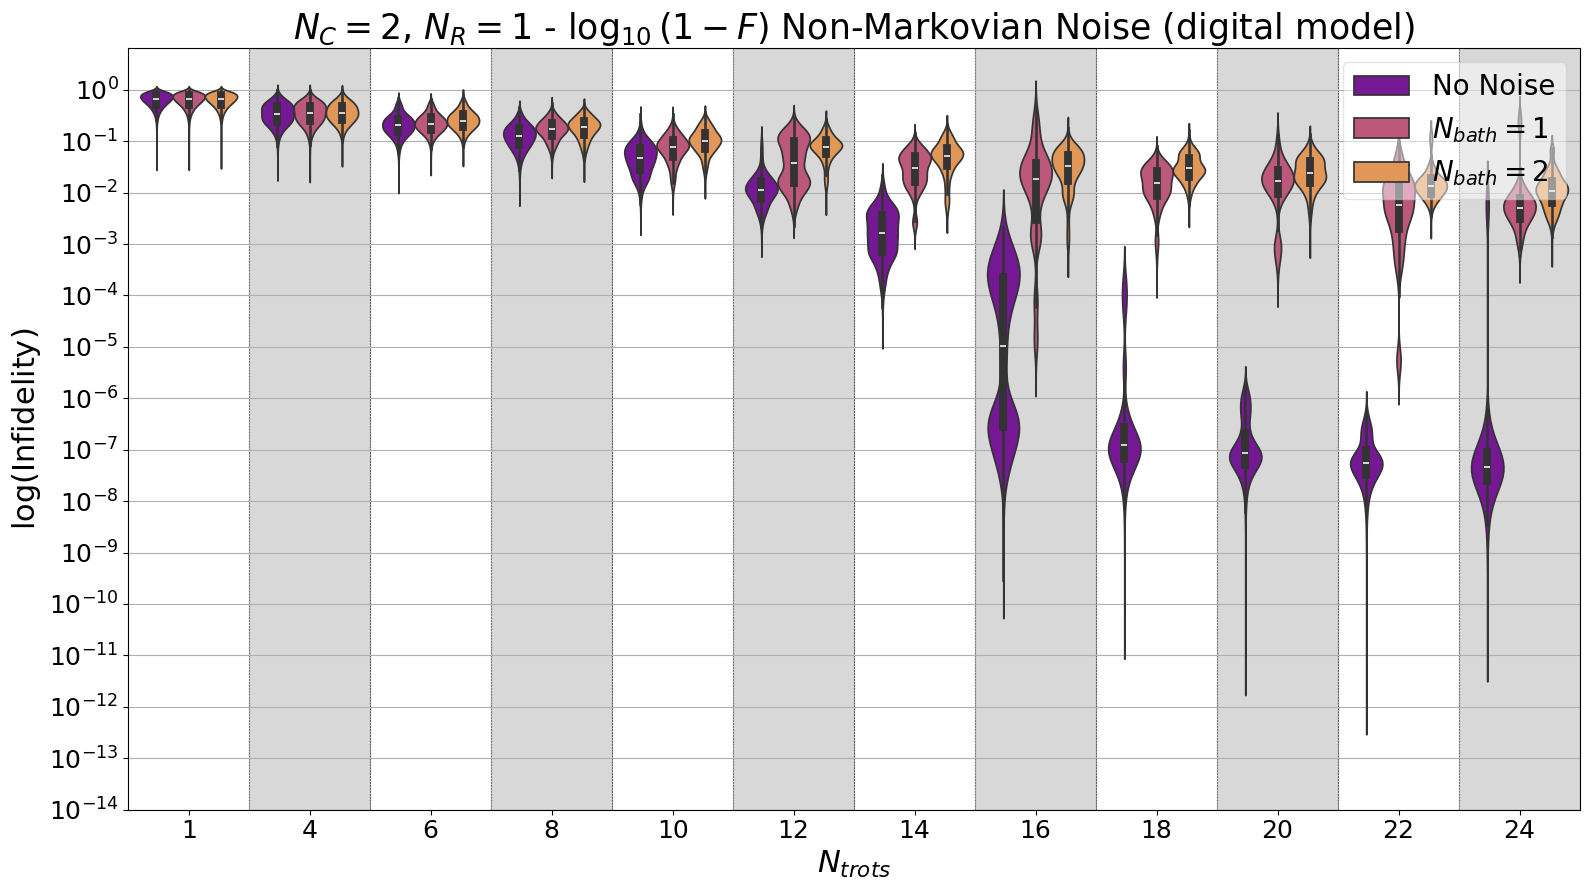

In [60]:
# Create violin plot
fig, ax = plt.subplots(figsize=(16, 9))

df_violin = pd.DataFrame(violin_plot_data, columns=['Trotter_Step', 'Num Bath', 'Log(Infidelity)'])

# Add vertical strips of color
unique_trotter_steps = sorted(df_violin['Trotter_Step'].unique())
positions = range(1, len(unique_trotter_steps) + 1)
for i, pos in enumerate(positions):
    ax.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4, zorder=0)
    if i % 2 == 0:  # Add strip for every other trotter step
        ax.axvspan(pos - 0.5, pos + 0.5, color='grey', alpha=0.3, zorder=0)

# Plot violin plot
sns.violinplot(x='Trotter_Step', y='Log(Infidelity)', hue='Num Bath', data=df_violin, ax=ax,
               palette='plasma', density_norm='width', inner="box",bw_adjust=2,  hue_order=bath_qubit_counts, zorder=2)


# Customize legend
handles, labels = ax.get_legend_handles_labels()
new_labels = ['No Noise' if int(label) == 0 else f'$N_{{bath}} = {label}$' for label in labels]
new_handles = [handles[0], handles[1], handles[2]]

legend = ax.legend(handles=new_handles, labels=new_labels, title_fontsize=16, loc='upper right', fontsize=20, fancybox=True, framealpha=0.5)


ax.yaxis.grid(True, zorder=1)
ax.xaxis.grid(False)

ax.set_title(f'$N_C = {N_ctrl}$, $N_R = {target_res}$ - $\log_{{10}}(1 - F)$ Non-Markovian Noise (digital model)', fontsize=25)
ax.set_xlabel('$N_{trots}$', fontsize=22)
ax.set_ylabel(r'$\log(\text{Infidelity})$', fontsize=22)
y_ticks = ax.get_yticks()

# # Set Y-ticks and labels
y_ticks = ax.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
min_tick = min(whole_y_ticks)
max_tick = max(whole_y_ticks)
whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
print(whole_y_ticks)
ax.set_yticks(whole_y_ticks)
ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)

plt.tight_layout()
plt.show()



[DEBUG] Fidelity Data: {6: {'0': [0.7711181549901517, 0.7966563265190516, 0.7973594482679557, 0.6330459232135232, 0.6798824689111649, 0.8717672532533199, 0.8088504817632354, 0.7557181652938539, 0.8386048282057146, 0.7927779409213476, 0.8705342087170664, 0.7736123294959868, 0.795169355837197, 0.5429102175265745, 0.7844255097413361, 0.8103388582639802, 0.7838528949943049, 0.8036423516751467, 0.5778445934891395, 0.7641243895768643, 0.9351943907581873, 0.6241935848571278, 0.8901988588353204, 0.7622030899803818, 0.6057506133227962, 0.7949455699695192, 0.7602611975316539, 0.6052913308311666, 0.6649035512836451, 0.7269244911201137, 0.5737566927493635, 0.8268226413317549, 0.7109026242576599, 0.8970263341803375, 0.8296378534294611, 0.7848923822484899], '1': [0.7711181552417921, 0.7966563266421376, 0.7973594483269565, 0.6330387447203061, 0.6798824688847649, 0.8717792483443805, 0.8088504816222566, 0.7557181647089078, 0.8386048281168492, 0.7927779410410493, 0.8705331859918853, 0.7736123295450487, 

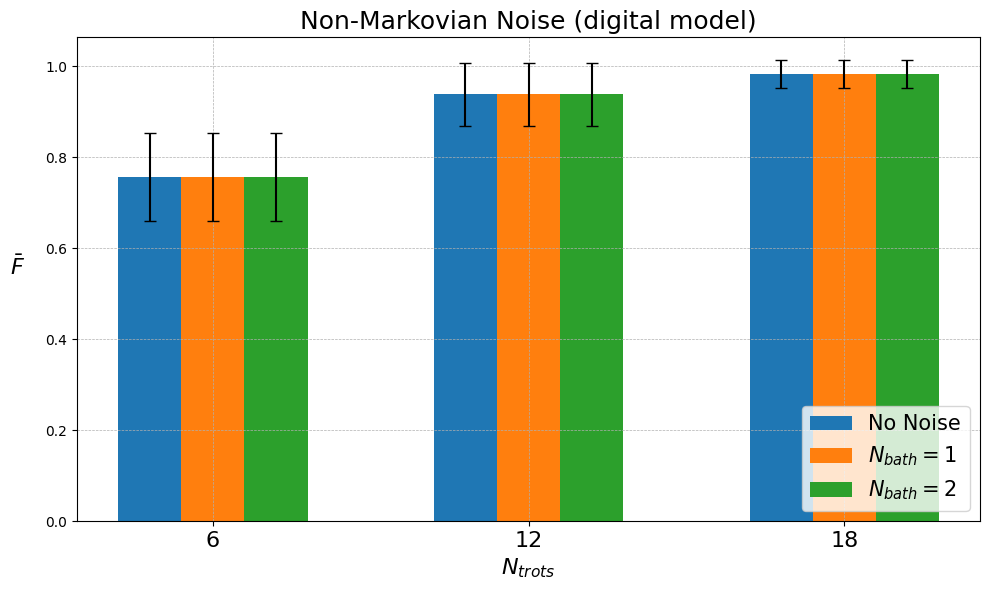

In [25]:

# Prepare data for plotting
fidelity_data = {}
trotter_steps = set()
infidelity_data = {}
for num_bath, gates in data.items():
    for gate, reservoir_data in gates.items():
        for reservoir_count, trotter_data in reservoir_data.items():
            for trotter_step, data_point in trotter_data.items():
                if trotter_step in trots:
                    trotter_steps.add(trotter_step)
                    fidelity = data_point['infidelity']
                    fidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).append(fidelity)

# Debugging fidelity data
debug_print("Fidelity Data", fidelity_data)

# Calculate averages and standard deviations
averaged_data = {}
standard_deviation_data = {}
for trotter_step, bath_data in fidelity_data.items():
    for num_bath, fidelities in bath_data.items():
        averaged_data.setdefault(trotter_step, {})[num_bath] = np.mean(fidelities)
        standard_deviation_data.setdefault(trotter_step, {})[num_bath] = np.std(fidelities)

debug_print("Averaged Data", averaged_data)
debug_print("Standard Deviation Data", standard_deviation_data)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
positions = np.arange(len(trots))
bar_width = 0.2

for idx, (num_bath, _) in enumerate(data.items()):
    means = [averaged_data.get(trot, {}).get(num_bath, 0) for trot in sorted(trots)]
    std_devs = [standard_deviation_data.get(trot, {}).get(num_bath, 0) for trot in sorted(trots)]
    label = 'No Noise' if int(num_bath) == 0 else f'$N_{{bath}} = {num_bath}$'
    ax.bar(positions + idx * bar_width, means, bar_width, yerr=std_devs, capsize=4, align='center', label=label)

ax.set_xlabel(r'$N_{trots}$', fontsize=16)
ax.set_ylabel(r'$\bar{F}$', rotation=0, fontsize=16, labelpad=20)
ax.set_title('Non-Markovian Noise (digital model)', fontsize=18)
ax.set_xticks(positions + bar_width * (len(data) - 1) / 2)
ax.set_xticklabels(sorted(trots), fontsize=16)
ax.legend(loc='lower right', fontsize=15)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [20]:

# Prepare data for plotting
fidelity_data = {}  # Data structure for storing fidelity information
infidelity_data = {}
trotter_steps = set()  # Set to keep track of all trotter steps encountered
target_res = 1

# Extract fidelity data for plotting
for num_bath, gates in data.items():
    for gate, reservoir_data in gates.items():
        for reservoir_count, trotter_data in reservoir_data.items():
            if reservoir_count != target_res:
                continue
            
            for trotter_step, data_point in trotter_data.items():
                if trotter_step in trots:
                    test_results = data_point['test_results']
                    test_results = np.clip(test_results, 0, 1)
                    infidelity_res = 1 - np.array(test_results)
                    trotter_steps.add(trotter_step)  # Keep track of trotter steps
                    fidelity = data_point['fidelity']  # Calculate fidelity from infidelity
                    fidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).append(fidelity)
                    infidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).extend(infidelity_res)
# Create violin plot
fig, ax = plt.subplots(figsize=(16, 9))

violin_plot_data = []
for trotter_step, res_data in infidelity_data.items():
    for num_bath, infidelities in res_data.items():
        for infidelity in infidelities:
            log_infidelity = np.log10(infidelity) if infidelity > 0 else -np.inf
            violin_plot_data.append((trotter_step, num_bath, log_infidelity))

df_violin = pd.DataFrame(violin_plot_data, columns=['Trotter_Step', 'Num Bath', 'Log(Infidelity)'])

# Add vertical strips of color
unique_trotter_steps = sorted(df_violin['Trotter_Step'].unique())
positions = range(1, len(unique_trotter_steps) + 1)
for i, pos in enumerate(positions):
    ax.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4, zorder=0)
    if i % 2 == 0:  # Add strip for every other trotter step
        ax.axvspan(pos - 0.5, pos + 0.5, color='grey', alpha=0.3, zorder=0)

# Plot violin plot
sns.violinplot(x='Trotter_Step', y='Log(Infidelity)', hue='Num Bath', data=df_violin, ax=ax,
               palette='plasma', density_norm='width', inner="point", bw_adjust=.75, hue_order=bath_qubit_counts, zorder=2)

# Add stripplot on top of the violin plot
#sns.stripplot(x='Trotter_Step', y='Log(Infidelity)', hue='Num Bath', data=df_violin, ax=ax,
#              palette='plasma', dodge=True, jitter=True, size=4, alpha=0.6, hue_order=bath_qubit_counts, zorder=3, marker='o')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
new_labels = ['No Noise' if int(label) == 0 else f'$N_{{bath}} = {label}$' for label in labels]
new_handles = [handles[0], handles[1], handles[2]]

legend = ax.legend(handles=new_handles, labels=new_labels, title_fontsize=16, loc='upper right', fontsize=20, fancybox=True, framealpha=0.5)

# Adjust z-order of violin plots, strip plots, and legend
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)

ax.yaxis.grid(True, zorder=1)
ax.xaxis.grid(False)

ax.set_title(f'$N_C = {N_ctrl}$, $N_R = {target_res}$ - $\log_{{10}}(1 - F)$ Non-Markovian Noise (digital model)', fontsize=25)
ax.set_xlabel('$N_{trots}$', fontsize=22)
ax.set_ylabel(r'$\log(\text{Infidelity})$', fontsize=22)
y_ticks = ax.get_yticks()

whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
ax.set_yticks(whole_y_ticks)
ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)

plt.tight_layout()
plt.show()


KeyError: 'fidelity'


DEBUG: log_infidelity_data structure:

DEBUG: Violin plot data:
Positions: []
Violin data length: 0

DEBUG: Colors used in violin plot:
[]


ValueError: zero-size array to reduction operation minimum which has no identity

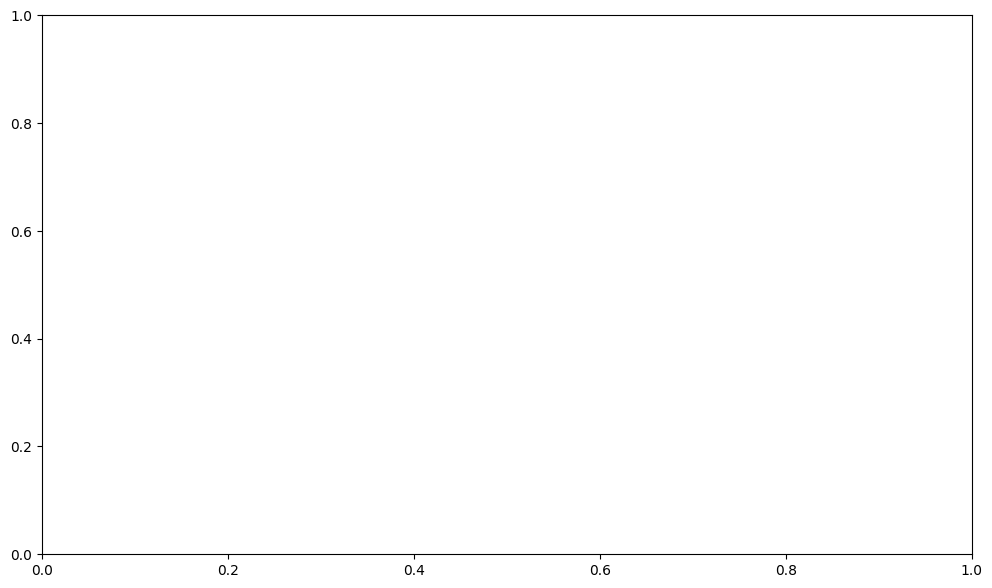

In [12]:
# Prepare data for plotting
log_infidelity_data = {}  # Data structure for storing log10(infidelity) information
trotter_steps = set()  # Set to keep track of all trotter steps encountered
target_res = 1

# Extract fidelity data for plotting
for num_bath, gates in data.items():
    for gate, reservoir_data in gates.items():
        for reservoir_count, trotter_data in reservoir_data.items():
            if reservoir_count == target_res:
                for trotter_step, data_point in trotter_data.items():
                    if trotter_step in trots:
                        trotter_steps.add(trotter_step)  # Keep track of trotter steps
                        fidelity = 1 - data_point['infidelity']  # Calculate fidelity from infidelity
                        infidelity = 1 - fidelity  # Convert fidelity to infidelity
                        log_infidelity = np.log10(np.clip(infidelity, 1e-14, 1.0))  # Log10 of infidelity
                        log_infidelity_data.setdefault(num_bath, {}).setdefault(trotter_step, []).append(log_infidelity)

# Debugging: Print the processed log_infidelity_data
print("\nDEBUG: log_infidelity_data structure:")
for num_bath, trotter_dict in log_infidelity_data.items():
    print(f"  N_bath = {num_bath}")
    for trotter_step, log_infidelities in trotter_dict.items():
        print(f"    N_trots = {trotter_step}: {len(log_infidelities)} entries")
        if len(log_infidelities) > 0:
            print(f"      Sample data: {log_infidelities[:5]}")  # Show sample entries

# Create violin plots
fig, ax = plt.subplots(figsize=(12, 7))
positions = []  # To store positions for each violin plot
violin_data = []  # To store the data for each violin
violin_colors = []  # Colors for each violin plot

# Prepare violin plot data
for idx, num_bath in enumerate(sorted(log_infidelity_data.keys(), key=int)):
    for trotter_step in sorted(log_infidelity_data[num_bath].keys()):
        positions.append(trotter_step)
        violin_data.append(log_infidelity_data[num_bath][trotter_step])
        color = 'purple' if int(num_bath) == 0 else 'orange' if int(num_bath) == 2 else 'pink'
        violin_colors.append(color)

# Debugging: Print the violin plot data
print("\nDEBUG: Violin plot data:")
print("Positions:", positions)
print("Violin data length:", len(violin_data))
for idx, data in enumerate(violin_data[:5]):  # Limit output for readability
    print(f"  Data[{idx}] length: {len(data)}")
    if len(data) > 0:
        print(f"    Sample values: {data[:5]}")

print("\nDEBUG: Colors used in violin plot:")
print(violin_colors[:5])  # Print the first few colors for validation

# Create the violin plot
parts = ax.violinplot(violin_data, positions=positions, showmeans=True, showextrema=True, widths=0.8)

# Apply custom colors
for patch, color in zip(parts['bodies'], violin_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_alpha(0.7)

# Customize plot
ax.set_yscale('log')
ax.set_xlabel(r'$N_{trots}$', fontsize=16)
ax.set_ylabel(r'$\log_{10}(\text{Infidelity})$', fontsize=16)
ax.set_title(f'$N_C = {N_ctrl}, N_R = {target_res}: \log_{10}(1-F)$ Non-Markovian Noise (digital model)', fontsize=18)

# Add legend
handles = [
    mpatches.Patch(color='purple', label='No Noise'),
    mpatches.Patch(color='pink', label=r'$N_{\text{bath}} = 1$'),
    mpatches.Patch(color='orange', label=r'$N_{\text{bath}} = 2$'),
]
ax.legend(handles=handles, loc='lower left', fontsize=12)

ax.grid(which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

KeyError: 6

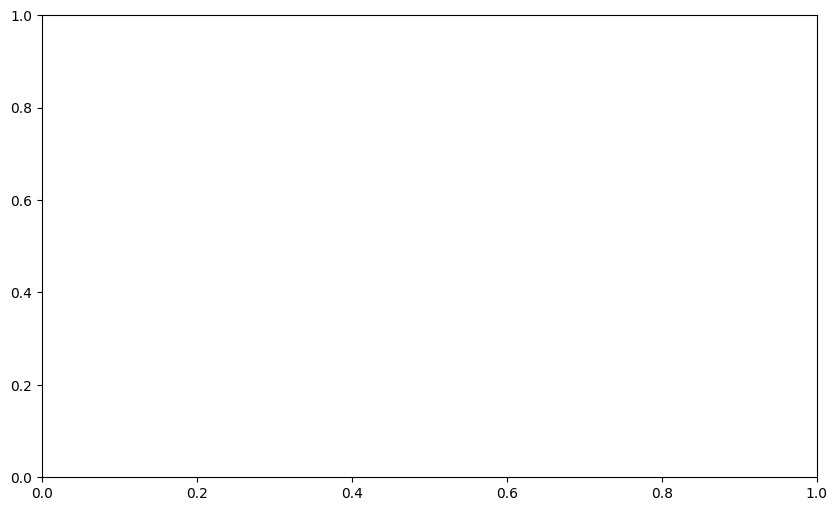

In [7]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path
import re

def is_valid_pickle_file(file_path):
    """
    Check if the file is a valid pickle file.
    """
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                pickle.load(f)
            return True
        else:
            return False
    except EOFError:
        return False


def extract_last_number(text):
    """
    Extract the last number from a string.
    """
    numbers = re.findall(r'\d+', text)
    return int(numbers[-1]) if numbers else 0


def read_jax_file(file_path):
    """
    Read relevant data from a JAX pickle file.
    """
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
        return df['avg_infidelity'][0], [float(i) for i in df['test_results'][0]]


# Initialize key parameters
N_ctrl = 2
training_size = 20
num_epochs = 1500
bath_factor = 0.1
trots = [6, 12, 18]
target_res = 1
base_path = f'/Users/sophieblock/Downloads/debug/digital_results_trainable_global/trainsize_{training_size}_epoch{num_epochs}_bath_factor_{bath_factor}/'

data = {str(i): {} for i in range(3)}  # Initialize for no noise, N_bath = 1, and N_bath = 2

# Process data
for bath_idx, num_bath in enumerate(data.keys()):
    bath_data = data[num_bath]
    ctrl_path = os.path.join(base_path, f"{num_bath}_num_baths/")

    for folder_name in sorted(os.listdir(ctrl_path)):
        if folder_name.startswith(f'U{N_ctrl}_'):
            gate = folder_name
            bath_data[gate] = {}

            gate_path = os.path.join(ctrl_path, gate)
            for subfolder in sorted(os.listdir(gate_path), key=extract_last_number):
                if 'reservoirs_' in subfolder:
                    reservoir_count = extract_last_number(subfolder)

                    subfolder_path = os.path.join(gate_path, subfolder)
                    for trotter_folder in sorted(os.listdir(subfolder_path), key=extract_last_number):
                        if 'trotter_step_' in trotter_folder:
                            trotter_step = extract_last_number(trotter_folder)

                            if bath_idx == 0:
                                trotter_path = os.path.join(subfolder_path, trotter_folder, 'bath_False')
                            else:
                                trotter_path = os.path.join(subfolder_path, trotter_folder)

                            if not os.path.exists(trotter_path):
                                continue

                            for file in os.listdir(trotter_path):
                                pickle_file = os.path.join(trotter_path, file)
                                if is_valid_pickle_file(Path(pickle_file)):
                                    infidelity, test_results = read_jax_file(pickle_file)
                                    if reservoir_count not in bath_data[gate]:
                                        bath_data[gate][reservoir_count] = {}
                                    if trotter_step not in bath_data[gate][reservoir_count]:
                                        bath_data[gate][reservoir_count][trotter_step] = {
                                            'infidelity': infidelity,
                                            'test_results': []
                                        }
                                    bath_data[gate][reservoir_count][trotter_step]['test_results'].extend(test_results)

# Process fidelities for plotting
fidelity_data = {}
averaged_data = {}
std_dev_data = {}
for num_bath, gates in data.items():
    for gate, reservoirs in gates.items():
        for reservoir_count, trotters in reservoirs.items():
            if reservoir_count == target_res:
                for trotter_step, results in trotters.items():
                    fidelity = 1 - results['infidelity']
                    test_results = np.clip(results['test_results'], 0, 1)
                    fidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).extend(test_results)
                    averaged_data.setdefault(trotter_step, {})[num_bath] = np.mean(test_results)
                    std_dev_data.setdefault(trotter_step, {})[num_bath] = np.std(test_results)

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.6 / len(data)  # Adjust bar width dynamically
positions = np.arange(len(trots))

for idx, (num_bath, _) in enumerate(data.items()):
    means = [averaged_data[trot].get(num_bath, 0) for trot in sorted(trots)]
    std_devs = [std_dev_data[trot].get(num_bath, 0) for trot in sorted(trots)]
    label = 'No Noise' if int(num_bath) == 0 else f'$N_{{bath}} = {num_bath}$'

    ax.bar(positions + idx * bar_width, means, bar_width, yerr=std_devs, capsize=4, label=label, zorder=3)

# Customize plot
ax.set_xlabel(r'$N_{trots}$', fontsize=16)
ax.set_ylabel(r'$\bar{F}$', fontsize=16, labelpad=20, rotation=0)
ax.set_title(f'$N_C = {N_ctrl}, N_R = {target_res}$: Non-Markovian Noise (Digital Model)', fontsize=18)
ax.set_xticks(positions + bar_width * (len(data) - 1) / 2)
ax.set_xticklabels(sorted(trots), fontsize=14)
ax.set_ylim([0.2, 1.01])
ax.grid(True, linestyle='--', linewidth=0.5, zorder=0)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.7, zorder=1)
ax.legend(loc='lower right', fontsize=12)

plt.tight_layout()
plt.show()

Processed Trotter Steps:
[6, 12, 18]

Available Averaged Data Keys:
dict_keys([])

Processing bath count 0:
Averaged data for bath 0: {}

Processing bath count 1:
Averaged data for bath 1: {}

Processing bath count 2:
Averaged data for bath 2: {}


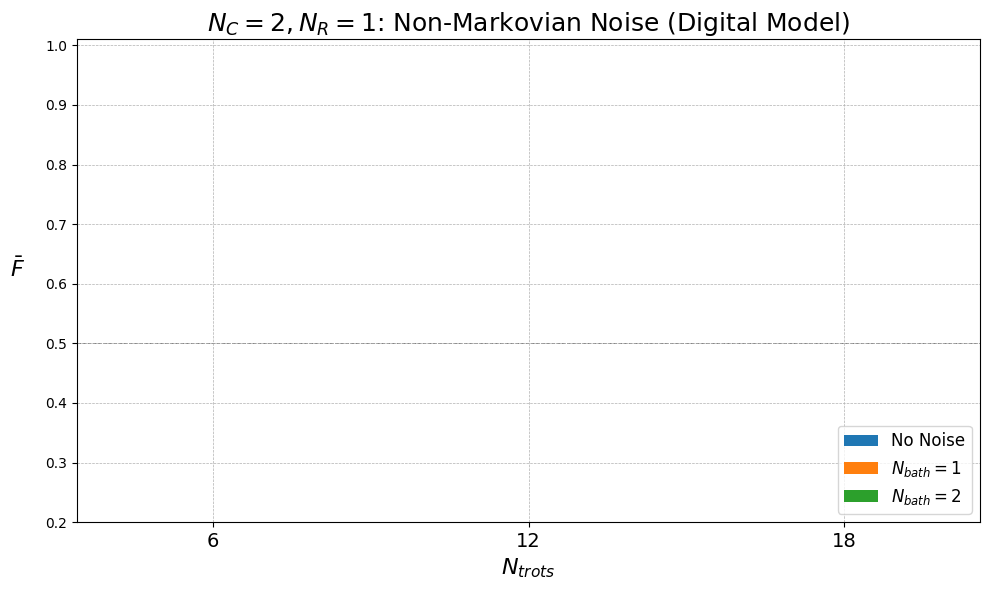

In [8]:
# Debugging: Check processed trotter steps and bath counts
print("Processed Trotter Steps:")
print(sorted(trots))
print("\nAvailable Averaged Data Keys:")
print(averaged_data.keys())

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.6 / len(data)  # Adjust bar width dynamically
positions = np.arange(len(trots))

for idx, (num_bath, _) in enumerate(data.items()):
    # Debugging: Print the data for each num_bath
    print(f"\nProcessing bath count {num_bath}:")
    print(f"Averaged data for bath {num_bath}: {averaged_data}")

    # Safely handle missing trotter steps
    means = [averaged_data.get(trot, {}).get(num_bath, 0) for trot in sorted(trots)]
    std_devs = [std_dev_data.get(trot, {}).get(num_bath, 0) for trot in sorted(trots)]

    label = 'No Noise' if int(num_bath) == 0 else f'$N_{{bath}} = {num_bath}$'

    ax.bar(positions + idx * bar_width, means, bar_width, yerr=std_devs, capsize=4, label=label, zorder=3)

# Customize plot
ax.set_xlabel(r'$N_{trots}$', fontsize=16)
ax.set_ylabel(r'$\bar{F}$', fontsize=16, labelpad=20, rotation=0)
ax.set_title(f'$N_C = {N_ctrl}, N_R = {target_res}$: Non-Markovian Noise (Digital Model)', fontsize=18)
ax.set_xticks(positions + bar_width * (len(data) - 1) / 2)
ax.set_xticklabels(sorted(trots), fontsize=14)
ax.set_ylim([0.2, 1.01])
ax.grid(True, linestyle='--', linewidth=0.5, zorder=0)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.7, zorder=1)
ax.legend(loc='lower right', fontsize=12)

plt.tight_layout()
plt.show()

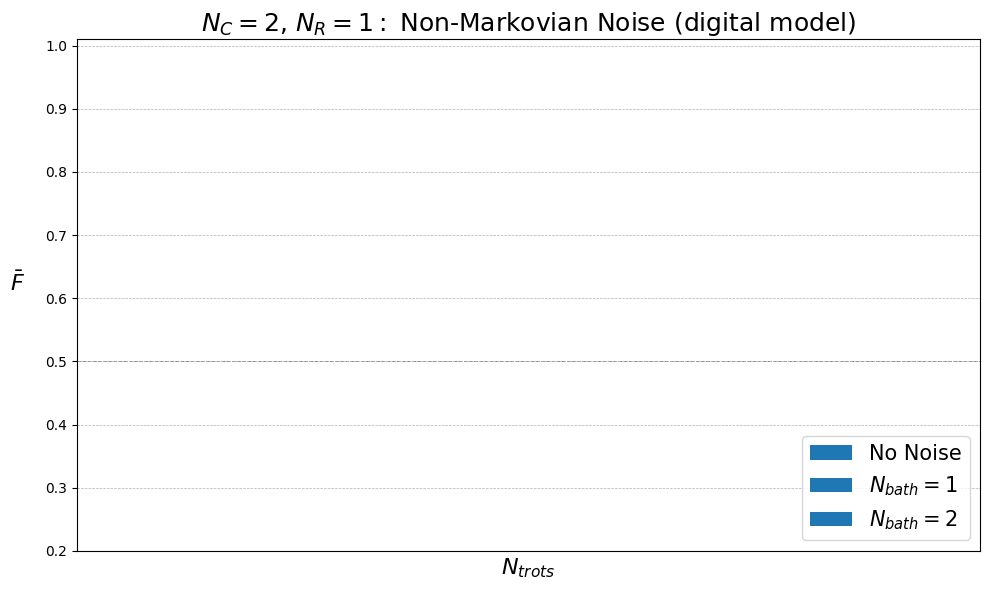

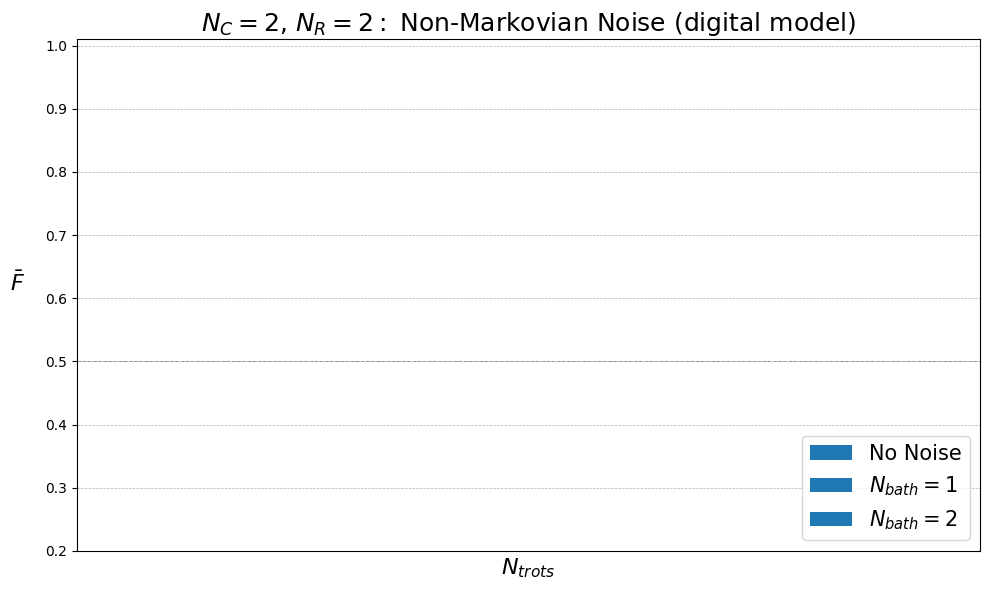

In [4]:
trots = [6,12,18]
# Initialize your plotting parameters
width = 0.6# Width of the bars in the bar plot
n_colors = 256  # Number of colors in the colormap for visual differentiation
n_groups = len(bath_qubit_counts)  # Number of groups, now based on bath counts
base_colormap = plt.cm.plasma  # Base colormap for visual appeal

# Define a custom colormap to enhance visual differentiation
values = np.linspace(0, 1, n_colors)**4  # Modify the distribution of the colormap
colors = base_colormap(values)
custom_colormap = mcolors.LinearSegmentedColormap.from_list('custom_plasma', colors, N=n_colors)

# Prepare data for plotting
fidelity_data = {}  # Data structure for storing fidelity information
trotter_steps = set()  # Set to keep track of all trotter steps encountered
target_res = 1
infidelity_data = {}
# Extract fidelity data for plotting
for num_bath, gates in data.items():
    for gate, reservoir_data in gates.items():
        for reservoir_count, trotter_data in reservoir_data.items():
            if reservoir_count == target_res:
                
            
                for trotter_step, data_point in trotter_data.items():
                    if trotter_step in trots:
                    
                        trotter_steps.add(trotter_step)  # Keep track of trotter steps
                        fidelity = 1 - data_point['infidelity']  # Calculate fidelity from infidelity
                        fidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).append(fidelity)
                        test_results = data_point['test_results']
                        test_results = np.clip(test_results, 0, 1)  # Ensure values are between 0 and 1

                        # Store infidelities directly
                        infidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).extend(test_results)

# Calculate average fidelity and standard deviation for plotting
averaged_data = {}
standard_deviation_data = {}
for trotter_step, bath_data in fidelity_data.items():
    
    for num_bath, fidelities in bath_data.items():
        averaged_data.setdefault(trotter_step, {})[num_bath] = np.mean(fidelities)
        standard_deviation_data.setdefault(trotter_step, {})[num_bath] = np.std(fidelities)

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = width / n_groups
positions = np.array(range(len(trotter_steps)))  # Base positions for each trotter step group


# Plot data
for idx, num_bath in enumerate(bath_qubit_counts):
    means = [averaged_data[ts].get(num_bath, 0) for ts in sorted(trotter_steps)]
    std_devs = [standard_deviation_data[ts].get(num_bath, 0) for ts in sorted(trotter_steps)]
    if int(num_bath) == 0:
        label = 'No Noise'
    else:
        label = f'$N_{{bath}} = {num_bath}$'
    ax.bar(positions + idx * bar_width, means, bar_width, yerr=std_devs, capsize=4, align='center',  label=label,zorder=3)

ax.set_xlabel(r'$N_{trots}$',fontsize=16)

ax.set_ylabel(r'$\bar{F}$',rotation=0,fontsize = 16,labelpad=20)
ax.set_title(f'$N_C = {N_ctrl}$, $N_R = {target_res}:$ Non-Markovian Noise (digital model)',fontsize=18)
ax.set_xticks(positions + bar_width * (n_groups - 1) / 2)
ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
ax.set_xticklabels(sorted(trotter_steps),fontsize=16)
ax.legend(loc='lower right',fontsize=15)
ax.grid(zorder=0)
ax.set_ylim([0.2, 1.01])  # Assuming fidelity values range from 0 to 1
ax.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=0)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.7, zorder=1)

plt.tight_layout()
plt.show()


# Prepare data for plotting
fidelity_data = {}  # Data structure for storing fidelity information
trotter_steps = set()  # Set to keep track of all trotter steps encountered
target_res = 2
infidelity_data = {}
# Extract fidelity data for plotting
for num_bath, gates in data.items():
    for gate, reservoir_data in gates.items():
        for reservoir_count, trotter_data in reservoir_data.items():
            if reservoir_count == target_res:
                
            
                for trotter_step, data_point in trotter_data.items():
                    if trotter_step in trots:
                    
                        trotter_steps.add(trotter_step)  # Keep track of trotter steps
                        fidelity = 1 - data_point['infidelity']  # Calculate fidelity from infidelity
                        fidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).append(fidelity)
                        test_results = data_point['test_results']
                        test_results = np.clip(test_results, 0, 1)  # Ensure values are between 0 and 1

                        # Store infidelities directly
                        infidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).extend(test_results)

# Calculate average fidelity and standard deviation for plotting
averaged_data = {}
standard_deviation_data = {}
for trotter_step, bath_data in fidelity_data.items():
    
    for num_bath, fidelities in bath_data.items():
        averaged_data.setdefault(trotter_step, {})[num_bath] = np.mean(fidelities)
        standard_deviation_data.setdefault(trotter_step, {})[num_bath] = np.std(fidelities)

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = width / n_groups
positions = np.array(range(len(trotter_steps)))  # Base positions for each trotter step group


# Plot data
for idx, num_bath in enumerate(bath_qubit_counts):
    means = [averaged_data[ts].get(num_bath, 0) for ts in sorted(trotter_steps)]
    std_devs = [standard_deviation_data[ts].get(num_bath, 0) for ts in sorted(trotter_steps)]
    if int(num_bath) == 0:
        label = 'No Noise'
    else:
        label = f'$N_{{bath}} = {num_bath}$'
    ax.bar(positions + idx * bar_width, means, bar_width, yerr=std_devs, capsize=4, align='center',  label=label,zorder=3)

ax.set_xlabel(r'$N_{trots}$',fontsize=16)

ax.set_ylabel(r'$\bar{F}$',rotation=0,fontsize = 16,labelpad=20)
ax.set_title(f'$N_C = {N_ctrl}$, $N_R = {target_res}:$ Non-Markovian Noise (digital model)',fontsize=18)
ax.set_xticks(positions + bar_width * (n_groups - 1) / 2)
ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
ax.set_xticklabels(sorted(trotter_steps),fontsize=16)
ax.legend(loc='lower right',fontsize=15)
ax.grid(zorder=0)
ax.set_ylim([0.2, 1.01])  # Assuming fidelity values range from 0 to 1
ax.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=0)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.7, zorder=1)

plt.tight_layout()
plt.show()

